In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import torch 
from torch.utils.data import TensorDataset, DataLoader

by_merge_map = {0:'0', 1:'1', 2:'2', 3:'3', 4:'4', 5:'5', 6:'6', 7:'7', 8:'8', 9:'9', 10:'A', 11:'B', 12:'C', 13:'D', 14:'E', 15:'F', 16:'G', 17:'H', 18:'I', 19:'J', 20:'K', 21:'L', 22:'M', 23:'N', 24:'O', 25:'P', 26:'Q', 27:'R', 28:'S', 29:'T', 30:'U', 31:'V', 32:'W', 33:'X', 34:'Y', 35:'Z', 36:'a', 37:'b', 38:'d', 39:'e', 40:'f', 41:'g', 42:'h', 43:'n', 44:'q', 45:'r', 46:'t'}
relevant_characters =  ['0','1','2','3','4','5','6','7','8','B','F','G','K','N','O','P','R','S','V','W','Y'] 

nums = relevant_characters[:9]
letters = relevant_characters[9:]

In [2]:
def flip_rotate(image):
    """ Flip ảnh và Xoay ảnh 90 độ ngược chiều kim đồng hồ"""
    W = 28
    H = 28
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

In [3]:
no_images = 100000

labels = np.zeros((no_images), dtype=int)
images = np.zeros((no_images, 28, 28), dtype=int)

i=0
with open(r'\\alfs1.physics.ox.ac.uk\al\howards/emnist-balanced-train.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    
    for row in csv_reader:
        labels[i] = int(row[0])
        images[i] = flip_rotate(np.array(row[1:],dtype=np.uint8).reshape((28,28)))
        i+=1
        if i==no_images:
            break

In [4]:
def remove_irrelevants(images, labels, keys_list, relevant_characters,):
    

    key_list = list(keys_list.keys())
    val_list = list(keys_list.values())


    position = [val_list.index(relevant_characters[i]) for i in range(len(relevant_characters))] 
    idxs = [i in position for i in labels]
    return images[idxs], labels[idxs]




def id_to_char(labels, keys_list):
    'convert the id into the corresponding character'
    labels = np.array(labels)
    return [keys_list[label] for label in labels]


def id_to_idx(labels):

    idxs = np.unique(labels)
    
    return [list(idxs).index(label) for label in labels]


In [5]:
images_num, labels_num,  = remove_irrelevants(images, labels, by_merge_map, nums)
images_let, labels_let_ = remove_irrelevants(images, labels, by_merge_map, letters)

labels_let = id_to_idx(labels_let_)

images_num = torch.tensor(images_num, dtype = torch.float32).unsqueeze(1)
labels_num = torch.tensor(labels_num,dtype=torch.int64)
images_let = torch.tensor(images_let, dtype = torch.float32).unsqueeze(1)
labels_let = torch.tensor(labels_let,dtype=torch.int64)

train_test_split = 0.8

train_num = int(len(images_num)*train_test_split)
train_let = int(len(images_let)*train_test_split)

train_images_num = images_num[:train_num]
train_labels_num = labels_num[:train_num]
test_images_num = images_num[train_num:]
test_labels_num = labels_num[train_num:]

train_images_let = images_let[:train_let]
train_labels_let = labels_let[:train_let]
test_images_let = images_let[train_let:]
test_labels_let = labels_let[train_let:]

In [6]:
dataset_train_num = TensorDataset(train_images_num, train_labels_num)
dataset_test_num = TensorDataset(test_images_num, test_labels_num)
dataset_train_let = TensorDataset(train_images_let, train_labels_let)
dataset_test_let = TensorDataset(test_images_let, test_labels_let)

batchsize = 32

dataloader_train_num = DataLoader(dataset_train_num, batch_size=batchsize, shuffle=True)
dataloader_test_num = DataLoader(dataset_test_num, batch_size=batchsize, shuffle=True)
dataloader_train_let = DataLoader(dataset_train_let, batch_size=batchsize, shuffle=True)
dataloader_test_let = DataLoader(dataset_test_let, batch_size=batchsize, shuffle=True)


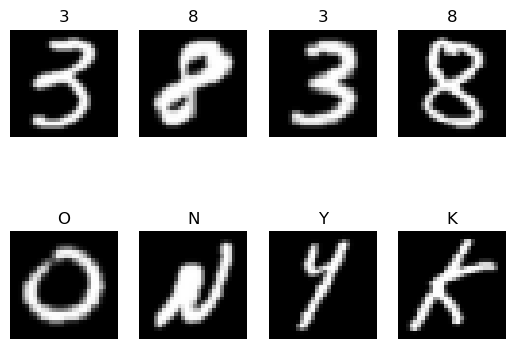

In [7]:
labels_num_char = id_to_char(labels_num, by_merge_map)
labels_let_char = id_to_char(labels_let_, by_merge_map)

fig,ax = plt.subplots(2,4)
for i in range(4):
    idx = np.random.randint(0, len(images_num))
    ax[0,i].imshow(images_num[idx,0], cmap='gray')
    ax[0,i].set_title(labels_num_char[idx])
    ax[0,i].axis('off')

    idx = np.random.randint(0, len(images_let))
    ax[1,i].imshow(images_let[idx,0], cmap='gray')
    ax[1,i].set_title(labels_let_char[idx])
    ax[1,i].axis('off')

plt.show()

Make some models 

In [8]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self, no_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, no_classes)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization



## Test the numbers Model

Epoch [1/10], Step [100/478], Loss: 1.2914
Epoch [1/10], Step [200/478], Loss: 0.1721
Epoch [1/10], Step [300/478], Loss: 0.7350
Epoch [1/10], Step [400/478], Loss: 0.1122
Epoch [2/10], Step [100/478], Loss: 0.2923
Epoch [2/10], Step [200/478], Loss: 0.0020
Epoch [2/10], Step [300/478], Loss: 0.3555
Epoch [2/10], Step [400/478], Loss: 0.2645
Epoch [3/10], Step [100/478], Loss: 0.1046
Epoch [3/10], Step [200/478], Loss: 0.0015
Epoch [3/10], Step [300/478], Loss: 0.0121
Epoch [3/10], Step [400/478], Loss: 0.1525
Epoch [4/10], Step [100/478], Loss: 0.0702
Epoch [4/10], Step [200/478], Loss: 0.0339
Epoch [4/10], Step [300/478], Loss: 0.0271
Epoch [4/10], Step [400/478], Loss: 0.0040
Epoch [5/10], Step [100/478], Loss: 0.0647
Epoch [5/10], Step [200/478], Loss: 0.0005
Epoch [5/10], Step [300/478], Loss: 0.0334
Epoch [5/10], Step [400/478], Loss: 0.0325
Epoch [6/10], Step [100/478], Loss: 0.0009
Epoch [6/10], Step [200/478], Loss: 0.0022
Epoch [6/10], Step [300/478], Loss: 0.1183
Epoch [6/10

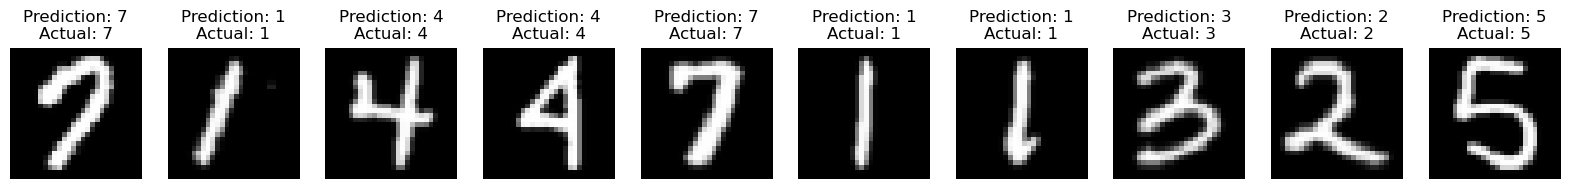

In [9]:
cnn_num = CNN(no_classes = len(np.unique(labels_num)))


num_epochs = 10
loss_func = nn.CrossEntropyLoss()   
optimizer = torch.optim.Adam(cnn_num.parameters(), lr=0.0001)   # optimize all cnn parameters

cnn_num.train()
        
# Train the model
total_step = len(dataset_train_num) // batchsize
    
for epoch in range(num_epochs):
    for i, (b_x, b_y) in enumerate(dataloader_train_num):
        
        output = cnn_num(b_x)[0]               
        loss = loss_func(output, b_y)
        
        optimizer.zero_grad()           
        loss.backward()    
        optimizer.step()                
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))


store_acc = []

cnn_num.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in dataloader_test_num:
        test_output, last_layer = cnn_num(images)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        store_acc.append(accuracy)

        
print('Test Accuracy of the model on the test images: %.2f' % torch.mean(torch.FloatTensor(store_acc)))
    
imgs, labels = dataset_test_num[:10]

test_output, last_layer = cnn_num(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()

fig,ax = plt.subplots(1,10,figsize=(20,2))
for i in range(10):
    ax[i].imshow(imgs[i].squeeze(), cmap='gray')
    ax[i].set_title(f'Prediction: {pred_y[i]}\nActual: {labels[i]}')
    ax[i].axis('off')

print(f'Prediction number: {pred_y}')
print(f'Actual number:     {np.array(labels)}')

## Test the letters model

In [10]:
def preds_to_char(preds, letters):
    return np.array([letters[i] for i in preds])

Epoch [1/10], Step [100/638], Loss: 0.3705
Epoch [1/10], Step [200/638], Loss: 0.3650
Epoch [1/10], Step [300/638], Loss: 0.1704
Epoch [1/10], Step [400/638], Loss: 0.0699
Epoch [1/10], Step [500/638], Loss: 0.0856
Epoch [1/10], Step [600/638], Loss: 0.2634
Epoch [2/10], Step [100/638], Loss: 0.2392
Epoch [2/10], Step [200/638], Loss: 0.3369
Epoch [2/10], Step [300/638], Loss: 0.0640
Epoch [2/10], Step [400/638], Loss: 0.2141
Epoch [2/10], Step [500/638], Loss: 0.0565
Epoch [2/10], Step [600/638], Loss: 0.2198
Epoch [3/10], Step [100/638], Loss: 0.1045
Epoch [3/10], Step [200/638], Loss: 0.1469
Epoch [3/10], Step [300/638], Loss: 0.1307
Epoch [3/10], Step [400/638], Loss: 0.0783
Epoch [3/10], Step [500/638], Loss: 0.0388
Epoch [3/10], Step [600/638], Loss: 0.0184
Epoch [4/10], Step [100/638], Loss: 0.0099
Epoch [4/10], Step [200/638], Loss: 0.2642
Epoch [4/10], Step [300/638], Loss: 0.0279
Epoch [4/10], Step [400/638], Loss: 0.0078
Epoch [4/10], Step [500/638], Loss: 0.0259
Epoch [4/10

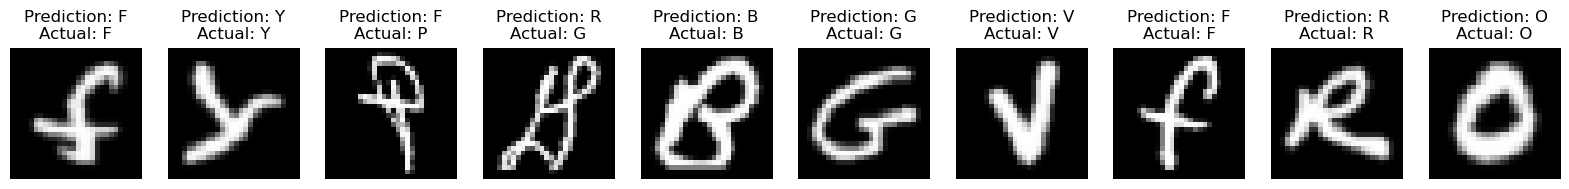

In [11]:
cnn_let = CNN(no_classes = len(np.unique(labels_let)))

num_epochs = 10
loss_func = nn.CrossEntropyLoss()   
optimizer = torch.optim.Adam(cnn_let.parameters(), lr=1e-3)   # optimize all cnn parameters

cnn_let.train()
        
# Train the model
total_step = len(dataset_train_let) // batchsize
    
for epoch in range(num_epochs):
    for i, (b_x, b_y) in enumerate(dataloader_train_let):
        
        output = cnn_let(b_x)[0]               
        loss = loss_func(output, b_y)
        
        optimizer.zero_grad()           
        loss.backward()    
        optimizer.step()                
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))


# test the model
store_acc = []

cnn_let.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in dataloader_test_let:
        test_output, last_layer = cnn_let(images)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        store_acc.append(accuracy)

        
print('Test Accuracy of the model on the test images: %.2f' % torch.mean(torch.FloatTensor(store_acc)))

#plot
imgs, labels = dataset_test_let[:10]
test_output, last_layer = cnn_let(imgs[:10])
pred_y = preds_to_char(torch.max(test_output, 1)[1].data.numpy().squeeze(),letters)
labels = preds_to_char(labels, letters)

fig,ax = plt.subplots(1,10,figsize=(20,2))
for i in range(10):
    ax[i].imshow(imgs[i].squeeze(), cmap='gray')
    ax[i].set_title(f'Prediction: {pred_y[i]}\nActual: {labels[i]}')
    ax[i].axis('off')

print(f'Prediction number: {pred_y}')
print(f'Actual number:     {labels}')